In [1]:
import os
import tensorflow as tf
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from matplotlib.image import imsave
from IPython.display import Audio

%matplotlib inline

# Mel_spec extraction

For extraction of mel spectrograms the dataset (folder where the raw audio data (wav encoded) is located in the data directory) has to be specified and if images should be saved, the variable save_img has to be set to True.

To generate different sized windows for training the cpc model, change the corresponding parameters T and k. If you use data not provided by us, you can also adjust the duration of the entire audio file used for the mel spectrogram.

In [ ]:
# ----------Params--------------------------------
dataset = 'GTZAN'  # wav audio data
save_img = True

# set dimensions based on cpc training arguments
T = 27 # samples (not seconds)
k = 3 # samples (not seconds)
audio_length = 30 # in seconds (entire audio file)
cpc_length = 4 # in seconds (length of T+k in sec)

In [ ]:
# path setting
orig_data_path = os.path.join(os.path.dirname(os.getcwd()), 'data', dataset)
save_data_path = os.path.join(os.path.dirname(os.getcwd()), 'data', f'{dataset}_melSpec')
save_image_path =os.path.join(os.path.dirname(os.getcwd()), 'data', f'{dataset}_melSpec_img')
if not os.path.isdir(save_data_path):
    os.mkdir(save_data_path)
if not os.path.isdir(save_image_path):
    os.mkdir(save_image_path)
    
# set mel encoding
n_fft = 2048  # standart for mel_spectograms of audio data
n_mels = 64

# ----------Encode audio files----------------------
audio_fns = os.listdir(orig_data_path)
audio_paths = [os.path.join(orig_data_path, fn) for fn in audio_fns]
save_fns = [os.path.splitext(audio_fn)[0] for audio_fn in audio_fns]
n_files = len(audio_paths)

# calculate suiting hop length
samples_per_cpc_timestep = n_mels # when equal to n_mels, will produce square images for encoder input
samples_per_cpc_audio = (T+k) * samples_per_cpc_timestep # amount of samples per cpc_audio
samples_per_audio_file = int(samples_per_cpc_audio / cpc_length * audio_length) # amount of samples per audio file
_, orig_sr = librosa.load(audio_paths[0]) # get sr_rate for calculation of the hop size
hop_length = int(orig_sr*audio_length // samples_per_audio_file)

for i, audio_path in enumerate(audio_paths):
    if i % 100 == 0:
        print(f'[INFO] - {i/n_files*100:0.2f}% finished')

    # load audio_data
    audio_binary = tf.io.read_file(audio_path)
    audio_file, sr = tf.audio.decode_wav(audio_binary,
                                         desired_channels=1,
                                         desired_samples=orig_sr*audio_length)
    audio_file = np.squeeze(audio_file.numpy())

    # convert audio to mel_spectrogram
    audio_file = librosa.feature.melspectrogram(audio_file,
                                                sr=sr,
                                                n_fft=n_fft,
                                                hop_length=hop_length,
                                                n_mels=n_mels)
    # convert power spec (amplitude squared) to decibels ('log scale' of amplitudes)
    audio_file_DB = librosa.power_to_db(audio_file,
                                        ref=np.min)
    
    # save the mel_spec and if desired an image of it
    orig_audio_fn = os.path.splitext(audio_path.split('/')[-1])[0]
    data_save_path = os.path.join(save_data_path, orig_audio_fn)
    np.save(data_save_path, audio_file_DB[:, :samples_per_audio_file])
    
    if save_img:
        save_fn = orig_audio_fn + '.svg'
        save_path = os.path.join(save_image_path, save_fn)
        imsave(save_path, audio_file_DB[:, :samples_per_audio_file])

    del audio_file, audio_file_DB, audio_binary

# Visualization of mel spectrograms

Here you can create a mel spectrogram from wav files stroed in the data directory. One can also classify a genre to show, when left blank a random sample will be taken.

In [6]:
# ----------Params--------------------------------
# define dataset and genre to show
dataset = 'GTZAN'
genre_to_display = 'pop'  # if None, randomly choosen
save_img = True
save_path_ = None  # if None, placed in cwd

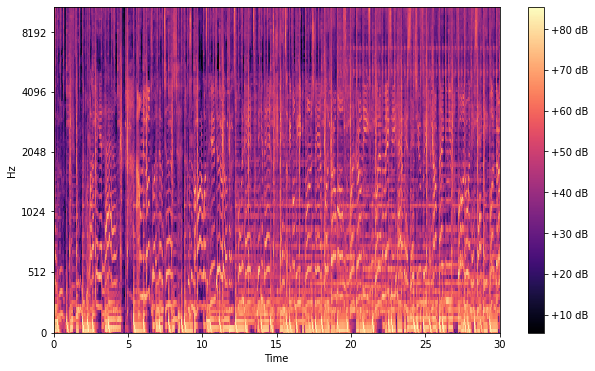

In [9]:
# get params and set mel spec specifig params
data_path = os.path.join(os.path.dirname(os.getcwd()), 'data', dataset)
hop_length = 256
n_mels = 128
n_fft = 2048
desired_audio_length = 30  # entire audio_file
audio_fns = os.listdir(data_path)

# subsamples desired genre
if genre_to_display is not None:
    audio_fns = [fn for fn in audio_fns if genre_to_display in fn]

audio_path = os.path.join(data_path, audio_fns[0])

# load and display audio file
audio_file, sr = librosa.load(audio_path, sr=None) 
Audio(audio_file, rate=sr)

# create mel_spectrum
audio_file = librosa.feature.melspectrogram(
    audio_file, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
audio_file_DB = librosa.power_to_db(audio_file, ref=np.min)[:, :]

# make fancy plot
plt.figure(figsize=(10, 6))
librosa.display.specshow(
    audio_file_DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

# save plot if desired
if save_img:
    if save_path_ is None:
        save_image_path = os.getcwd()
    else:
        save_image_path = save_path_
        
    orig_audio_fn = os.path.splitext(audio_path.split('/')[-1])[0]
    save_fn = orig_audio_fn + '_melSpectogram.svg'
    save_path = os.path.join(save_image_path, save_fn)
    imsave(save_path, audio_file_DB[:, :])
    
    del save_image_path

plt.show()